# Búsqueda de parametros ideales para KNN y KNN+PCA.

#### En este notebook buscamos cual es la cantidad k de vecinos ideal para el algoritmo de KNN. Luego buscamos cual es el par ideal de k vecinos y alpha componentes principales para el algoritmo de KNN+PCA.

## Compilando el módulo desde C++

#### Compilamos el modulo desde C++. En CMakeList.txt está seteado que se corra con OpenMP para paralelizar operaciones

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: no se puede crear el directorio «build»: El archivo ya existe
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Found libomp without any special flags
-- pybind11 v2.6.3 dev1
-- Found PythonInterp: /home/laureano/Documentos/met2021/grupal/metnum-1c2021-tp2/tp2/bin/python (found vers

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/home/laureano/Documentos/met2021/grupal/metnum-1c2021-tp2/notebooks
Python 3.8.5


## Explorando los datos

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from sklearn import metrics


In [4]:
df_train = pd.read_csv("../data/train.csv")

#### Leemos el csv que tiene en cada fila una imagen de un digito y su etiqueta asociada.

In [5]:
df_train = sk.utils.shuffle(df_train, random_state = 42)
#df_train = df_train[:5000]

In [6]:
cutting_point = len(df_train) - (len(df_train)//5)
df_test = df_train[cutting_point:]
df_train = df_train[:cutting_point]


#### Dividimos el set de datos en dos partes. Una parte para entrenar con cross validation y una parte para validar nuestro clasificador. Entrenamos con el 80% de los datos y validamos con el 20% restante. Si se quiere entrenar con el 100% de los datos comentar este bloque. Esto ultimo serviría para testear con kaggle.

In [7]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)
X_test = df_test[df_test.columns[1:]].values
y_test = df_test["label"].values.reshape(-1, 1)
X.shape, y.shape, X_test.shape, y_test.shape

((33600, 784), (33600, 1), (8400, 784), (8400, 1))

In [8]:
#### Pasamos los datos del set a un formato cómodo para trabajar. Chequeamos su forma.

## Validación cruzada

Implementamos una función para obtener las diferentes particiones consideradas para la validación cruzada. Arbitrariamente decidimos hacer validación cruzada de 5 folds. La cantidad de folds ideal es calculada en la notebook "K Fold".

In [9]:
def get_KFold_sets(x,y,K=5):
    X_trains = []
    Y_trains = []
    X_vals = []
    Y_vals = []
    bucket_size = len(x)//K
    for i in range(K):
        low = bucket_size*i
        high = bucket_size * (i+1)
        X_vals.append(x[low :high])
        Y_vals.append(y[low :high])
        X_train,Y_train = x[:low], y[:low]
        X_train = np.concatenate((X_train,x[high:]),axis=0)
        Y_train = np.concatenate((Y_train,y[high:]),axis=0)
        X_trains.append(X_train)
        Y_trains.append(Y_train)
    return X_trains,Y_trains,X_vals,Y_vals

In [10]:
X_trains, Y_trains, X_vals, Y_vals = get_KFold_sets(X,y)

## Métricas

#### Buscamos cuales son los parametros "ideales" para nuestros clasificadores. Notemos que si bien el accuracy(exactitud) es un buen indicador de la calidad de nuestros parametros elegidos, también existen otras métricas que sirven para evaluarlo.

#### Dentro de estas otras métricas tenemos: 
    Tiempo de ejecución
    Exactitud
    Curvas de precisión/recall
    F1-Score
    Kappa de Cohen
   

#### Decidimos darle mayor importancia al accuracy de los clasificadores, y en caso de obtener varios clasificadores con accuracy similar quedarnos con aquel que tenga un f1-score conveniente. Tomamos los f1-score de las 10 clases de los 5 clasificadores de mayor accuracy. Nos quedamos con aquel clasificador cuyo minimo f1-score de clase es el mayor entre todos los minimos.

## Búsqueda de k ideal de KNN

#### Buscamos dentro del intervalo [1,101] con saltos de a 2, para darnos una idea de donde pueden ubicarse los k de mejor accuracy.

In [11]:
accsk1_a_101 = []

from tqdm import tqdm
for k in tqdm(range(1,102,2)):
    acc = 0
    for i in range(len(X_trains)): 
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains[i],Y_trains[i])
        y_pred = clf.predict(X_vals[i])
        acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accsk1_a_101.append((acc,k))

100%|██████████| 51/51 [47:40<00:00, 56.09s/it]


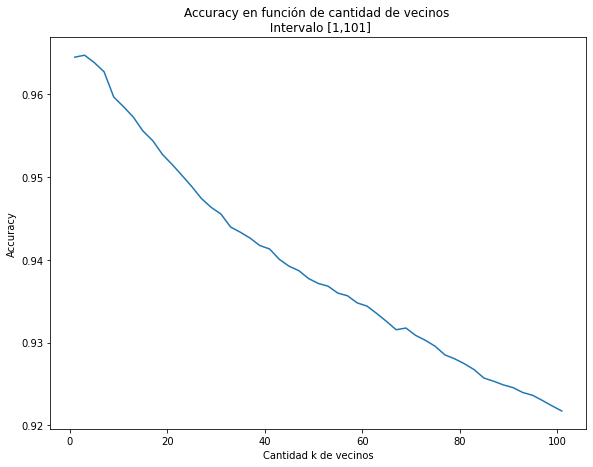

In [13]:
acc_grafico, k_grafico = zip(*accsk1_a_101)
plt.figure(figsize = (6.4 * 1.5, 4.8 * 1.5))
plt.title("Accuracy en función de cantidad de vecinos \n Intervalo [1,101]")
plt.xlabel("Cantidad k de vecinos")
plt.ylabel("Accuracy")
plt.plot(k_grafico,acc_grafico)
plt.savefig('./graficosSinPeso/accsk1_a_101.png')


#### Observamos que las k que resultan en un mejor accuracy están en los números mas bajos. Buscamos dentro del intervalo [1,15] con saltos de a 1 para identificar cuales son los k que resultan en una mejor accuracy.

In [14]:
accsk1_a_15 = []

for k in tqdm(range(1,16,1)):
    acc = 0
    for i in range(len(X_trains)):
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains[i],Y_trains[i])
        y_pred = clf.predict(X_vals[i])
        acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accsk1_a_15.append((acc,k))

100%|██████████| 15/15 [17:45<00:00, 71.01s/it]


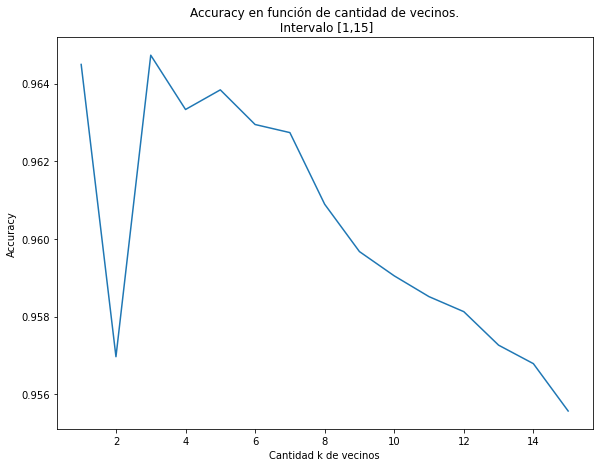

In [16]:

acc_grafico, k_grafico = zip(*accsk1_a_15)
plt.figure(figsize = (6.4 * 1.5, 4.8 * 1.5))
plt.title("Accuracy en función de cantidad de vecinos.\n Intervalo [1,15]")
plt.xlabel("Cantidad k de vecinos")
plt.ylabel("Accuracy")
plt.plot(k_grafico,acc_grafico)
plt.savefig('./graficosSinPeso/accsk1_a_15.png')

In [17]:
accsk1_a_15.sort(reverse = True)
mejores5k = accsk1_a_15
mejores5k = mejores5k[:5]
print(mejores5k)

[(0.9647321428571429, 3), (0.9644940476190478, 1), (0.9638392857142856, 5), (0.9633333333333333, 4), (0.9629464285714286, 6)]


#### Obtenemos los 5 mejores k en accuracy. Observamos que todos tienen una accuracy mayor a 0.961 y menor a 0.964. Como estas accuracys son muy similares decidimos quedarnos con la que tenga un f1-score conveniente.

In [18]:
minimosf1 = []
digitosConPeoresF1 = []
for tupla in mejores5k:
    clf = metnum.KNNClassifier(tupla[1])
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    f1_scorePorClase = sk.metrics.f1_score(y_test,y_pred, average = None)
    digitosConPeoresF1.append(np.where(f1_scorePorClase == np.amin(f1_scorePorClase))[0][0])
    minimosf1.append((np.amin(f1_scorePorClase),(tupla[1])))
    

minimosf1.sort(reverse = True)
print(minimosf1)
print(digitosConPeoresF1)
print("Nuestra k ideal de vecinos es ", minimosf1[0][1])

[(0.9531751122514432, 3), (0.9525032092426188, 6), (0.9525032092426188, 5), (0.9521028037383177, 1), (0.9510939510939511, 4)]
[8, 9, 8, 8, 8]
Nuestra k ideal de vecinos es  3


In [19]:
print(np.amin(minimosf1[0][0]))

0.9531751122514432


#### Observamos que la k de mayor accuracy coincide con la k cuyo minimo f1 score es el conveniente. Luego, nuestro k ideal es 3.

## Búsqueda del par de k vecinos y alpha componentes ideal.

#### Partimos de nuestra k ideal knn para buscar el alpha ideal asociado. Luego buscamos en un rango acotado de k's y alpha's si es que existe una mejor combinación de parámetros.

In [20]:

k = 3 ### "K ideal obtenida en KNN"
accsalpha1_a_101 = []

for alpha in tqdm(range(1,102,10)):
    acc = 0
    X_trains_transformadas = []
    X_vals_transformadas = []
    for i in range(len(X_trains)):
        pca = metnum.PCA(alpha)
        pca.fit(X_trains[i]) #%time 
        X_trains_transformadas.append(pca.transform(X_trains[i]))
        X_vals_transformadas.append(pca.transform(X_vals[i]))
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains_transformadas[i],Y_trains[i])
        y_pred = clf.predict(X_vals_transformadas[i])
        acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accsalpha1_a_101.append((acc,alpha))


100%|██████████| 11/11 [03:08<00:00, 17.13s/it]


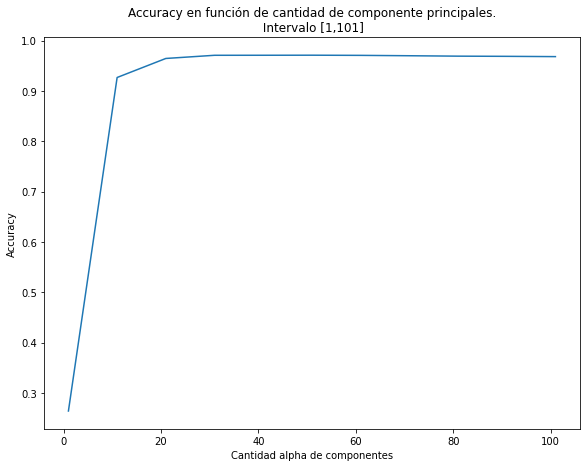

In [21]:
acc_grafico, alpha_grafico = zip(*accsalpha1_a_101)
plt.figure(figsize = (6.4 * 1.5, 4.8 * 1.5))
plt.title("Accuracy en función de cantidad de componente principales.\n Intervalo [1,101]")
plt.xlabel("Cantidad alpha de componentes")
plt.ylabel("Accuracy")
plt.plot(alpha_grafico,acc_grafico)
plt.savefig('./graficosSinPeso/accsalpha1_a_101.png')


### Observamos un "codito". Si bien se aprecia que a mayor cantidad de alpha componentes se obtiene una mayor accuracy, podemos identificar que este crecimiento en accuracy se vuelve paulatino pasado los 20 componentes.

In [22]:
k = 3 
accsalpha10_a_50 = []

for alpha in tqdm(range(10,51,5)):
    acc = 0
    X_trains_transformadas = []
    X_vals_transformadas = []
    for i in range(len(X_trains)):
        pca = metnum.PCA(alpha)
        pca.fit(X_trains[i])
        X_trains_transformadas.append(pca.transform(X_trains[i]))
        X_vals_transformadas.append(pca.transform(X_vals[i]))
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains_transformadas[i],Y_trains[i])
        y_pred = clf.predict(X_vals_transformadas[i])
        acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accsalpha10_a_50.append((acc,alpha))

100%|██████████| 9/9 [01:29<00:00,  9.92s/it]


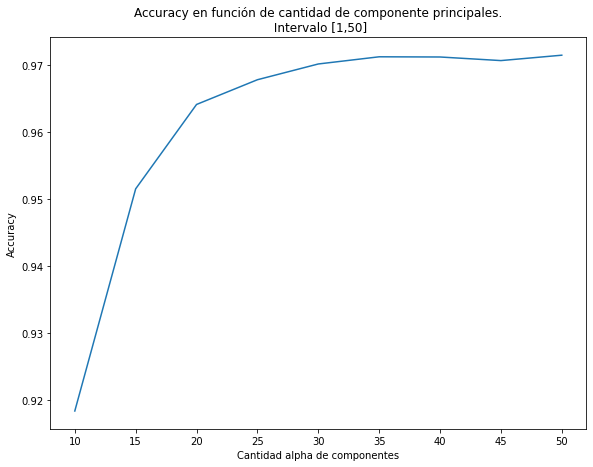

In [23]:
acc_grafico, alpha_grafico = zip(*accsalpha10_a_50)
plt.figure(figsize = (6.4 * 1.5, 4.8 * 1.5))
plt.title("Accuracy en función de cantidad de componente principales.\n Intervalo [1,50]")
plt.xlabel("Cantidad alpha de componentes")
plt.ylabel("Accuracy")
plt.plot(alpha_grafico,acc_grafico)
plt.savefig('./graficosSinPeso/accsalpha10_a_50.png')

In [24]:
#CRITERIO DE TIEMPO DE EJECUCION. Lau: Tengo que discutirlo con Dani.

#### No queda claro a simple vista cual es el alpha que deberiamos tomar. Sabemos que el tiempo de ejecución aumenta en función de la cantidad de componentes principales. Decidimos calcular cual es la accuracy que nos da el mejor alpha y quedarnos con el primer alpha que tenga un accuracy que diste como maximo un 5% de la mejor.

In [25]:
k = 3 
accsalphasgrandes = []

for alpha in tqdm([100,200,300,400,500,600,700,750]):
    acc = 0
    X_trains_transformadas = []
    X_vals_transformadas = []
    for i in range(len(X_trains)):
        pca = metnum.PCA(alpha)
        pca.fit(X_trains[i])
        X_trains_transformadas.append(pca.transform(X_trains[i]))
        X_vals_transformadas.append(pca.transform(X_vals[i]))
        clf = metnum.KNNClassifier(k)
        clf.fit(X_trains_transformadas[i],Y_trains[i])
        y_pred = clf.predict(X_vals_transformadas[i])
        acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
    acc = acc/len(X_trains)
    accsalphasgrandes.append((acc,alpha))

 67%|██████▋   | 8/12 [27:10<13:35, 203.85s/it]


KeyboardInterrupt: 

In [ ]:
accsalphasgrandes.sort(reverse = True)
print(accsalphasgrandes)

#### Queremos investigar en un entorno cerca de nuestro par de k y alpha ideal. Para eso calculamos el accuracy para k en el intervalo [1,15] y alpha en el intervalo [25,35]

In [ ]:
accspar = []
for k in tqdm(range(1,16,1)):
    for alpha in range(25,36):
        acc = 0
        X_trains_transformadas = []
        X_vals_transformadas = []
        for i in range(len(X_trains)):
            pca = metnum.PCA(alpha)
            pca.fit(X_trains[i])
            X_trains_transformadas.append(pca.transform(X_trains[i]))
            X_vals_transformadas.append(pca.transform(X_vals[i]))
            clf = metnum.KNNClassifier(k)
            clf.fit(X_trains_transformadas[i],Y_trains[i])
            y_pred = clf.predict(X_vals_transformadas[i])
            acc += sk.metrics.accuracy_score(Y_vals[i], y_pred)
        acc = acc/len(X_trains)
        accspar.append((acc,k,alpha)) 

In [ ]:
accspar.sort(reverse = True)
mejores5pares = accspar
mejores5pares = mejores5pares[:5]
print(mejores5pares)

#### Observamos que nuestro par elegido es el que tiene mejor accuracy en su entorno. Nuevamente, tomamos los mejores 5 y nos quedamos con el que tenga f1 score conveniente.

In [ ]:
minimosf1 = []
digitosConPeoresF1 = []
for tupla in mejores5pares:
    clf = metnum.KNNClassifier(tupla[1])
    clf.fit(X, y)
    y_pred = clf.predict(X_test)
    f1_scorePorClase = sk.metrics.f1_score(y_test,y_pred, average = None)
    digitosConPeoresF1.append(np.where(f1_scorePorClase == np.amin(f1_scorePorClase))[0][0])
    minimosf1.append((np.amin(f1_scorePorClase),(tupla[1],tupla[2])))
    
minimosf1.sort(reverse = True)
print(minimosf1)
print(digitosConPeoresF1)
print("Nuestra par ideal es ", (minimosf1[0][1]))